<a href="https://colab.research.google.com/github/tushar-semwal/fedperf/blob/main/Santiago/Shakespeare/FedMed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FedPerf - Shakespeare + FedMed algorithm

## Setup & Dependencies Installation

In [ ]:
%%capture
!pip install torchsummaryX unidecode

In [ ]:
%load_ext tensorboard

import copy
from functools import reduce
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import time
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import Sampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torchsummaryX import summary as summaryx
from torchvision import transforms, utils, datasets
from tqdm.notebook import tqdm
from unidecode import unidecode

%matplotlib inline

# Check assigned GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# set manual seed for reproducibility
RANDOM_SEED = 42

# general reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Sun Apr 25 12:46:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Mount GDrive

In [ ]:
BASE_DIR = '/content/drive/MyDrive/FedPerf/shakespeare/FedMed'

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.makedirs(BASE_DIR, exist_ok=True)
except:
    print("WARNING: Results won't be stored on GDrive")
    BASE_DIR = './'



Mounted at /content/drive


## Loading Dataset

In [ ]:
!rm -Rf data
!mkdir -p data scripts

In [ ]:
GENERATE_DATASET = False  # If False, download the dataset provided by the q-FFL paper
DATA_DIR = 'data/'
# Dataset generation params
SAMPLES_FRACTION = 1.  # If using an already generated dataset
# SAMPLES_FRACTION = 0.2  # Fraction of total samples in the dataset - FedProx default script
# SAMPLES_FRACTION = 0.05  # Fraction of total samples in the dataset - qFFL
TRAIN_FRACTION = 0.8  # Train set size
MIN_SAMPLES = 0  # Min samples per client (for filtering purposes) - FedProx
# MIN_SAMPLES = 64  # Min samples per client (for filtering purposes) - qFFL

In [ ]:
# Download raw dataset
# !wget https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt -O data/shakespeare.txt
!wget --adjust-extension http://www.gutenberg.org/files/100/100-0.txt -O data/shakespeare.txt

--2021-04-25 12:47:10--  http://www.gutenberg.org/files/100/100-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5757108 (5.5M) [text/plain]
Saving to: ‘data/shakespeare.txt’

data/shakespeare.tx 100%[===================>]   5.49M  29.7MB/s    in 0.2s    

2021-04-25 12:47:10 (29.7 MB/s) - ‘data/shakespeare.txt’ saved [5757108/5757108]



In [ ]:
if not GENERATE_DATASET:
    !rm -Rf data/train data/test
    !gdown --id 1n46Mftp3_ahRi1Z6jYhEriyLtdRDS1tD  # Download Shakespeare dataset used by the FedProx paper
    !unzip shakespeare.zip
    !mv -f shakespeare_paper/train data/
    !mv -f shakespeare_paper/test data/
    !rm -R shakespeare_paper/ shakespeare.zip


Downloading...
From: https://drive.google.com/uc?id=1n46Mftp3_ahRi1Z6jYhEriyLtdRDS1tD
To: /content/shakespeare.zip
2.96MB [00:00, 46.5MB/s]
Archive:  shakespeare.zip
   creating: shakespeare_paper/
   creating: shakespeare_paper/test/
  inflating: shakespeare_paper/test/all_data_niid_2_keep_0_test_8.json  
   creating: shakespeare_paper/train/
  inflating: shakespeare_paper/train/all_data_niid_2_keep_0_train_8.json  


In [ ]:
corpus = []
with open('data/shakespeare.txt', 'r') as f:
    data = list(unidecode(f.read()))
    corpus = list(set(list(data)))
print('Corpus Length:', len(corpus))

Corpus Length: 90


#### Dataset Preprocessing script

In [ ]:
%%capture
if GENERATE_DATASET:
    # Download dataset generation scripts
    !wget https://raw.githubusercontent.com/ml-lab/FedProx/master/data/shakespeare/preprocess/preprocess_shakespeare.py -O scripts/preprocess_shakespeare.py
    !wget https://raw.githubusercontent.com/ml-lab/FedProx/master/data/shakespeare/preprocess/shake_utils.py -O scripts/shake_utils.py
    !wget https://raw.githubusercontent.com/ml-lab/FedProx/master/data/shakespeare/preprocess/gen_all_data.py -O scripts/gen_all_data.py

    # Download data preprocessing scripts
    !wget https://raw.githubusercontent.com/ml-lab/FedProx/master/utils/sample.py -O scripts/sample.py
    !wget https://raw.githubusercontent.com/ml-lab/FedProx/master/utils/remove_users.py -O scripts/remove_users.py

In [ ]:
# Running scripts
if GENERATE_DATASET:
    !mkdir -p data/raw_data data/all_data data/train data/test
    !python scripts/preprocess_shakespeare.py data/shakespeare.txt data/raw_data
    !python scripts/gen_all_data.py

#### Dataset class

In [ ]:
class ShakespeareDataset(Dataset):
    def __init__(self, x, y, corpus, seq_length):
        self.x = x
        self.y = y
        self.corpus = corpus
        self.corpus_size = len(self.corpus)
        super(ShakespeareDataset, self).__init__()

    def __len__(self):
        return len(self.x)

    def __repr__(self):
        return f'{self.__class__} - (length: {self.__len__()})'

    def __getitem__(self, i):
        input_seq = self.x[i]
        next_char = self.y[i]
        # print('\tgetitem', i, input_seq, next_char)
        input_value = self.text2charindxs(input_seq)
        target_value = self.get_label_from_char(next_char)
        return input_value, target_value

    def text2charindxs(self, text):
        tensor = torch.zeros(len(text), dtype=torch.int32)
        for i, c in enumerate(text):
            tensor[i] = self.get_label_from_char(c)
        return tensor

    def get_label_from_char(self, c):
        return self.corpus.index(c)

    def get_char_from_label(self, l):
        return self.corpus[l]

##### Federated Dataset

In [ ]:
class ShakespeareFedDataset(ShakespeareDataset):
    def __init__(self, x, y, corpus, seq_length):
        super(ShakespeareFedDataset, self).__init__(x, y, corpus, seq_length)

    def dataloader(self, batch_size, shuffle=True):
        return DataLoader(self,
                          batch_size=batch_size,
                          shuffle=shuffle,
                          num_workers=0)


## Partitioning & Data Loaders

### IID

In [ ]:
def iid_partition_(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

In [ ]:
def iid_partition(corpus, seq_length=80, val_split=False):

    train_file = [os.path.join(DATA_DIR, 'train', f) for f in os.listdir(f'{DATA_DIR}/train') if f.endswith('.json')][0]
    test_file = [os.path.join(DATA_DIR, 'test', f) for f in os.listdir(f'{DATA_DIR}/test') if f.endswith('.json')][0]

    with open(train_file, 'r') as file:
        data_train = json.loads(unidecode(file.read()))

    with open(test_file, 'r') as file:
        data_test = json.loads(unidecode(file.read()))

    
    total_samples_train = sum(data_train['num_samples'])

    data_dict = {}

    x_train, y_train = [], []
    x_test, y_test = [], []
    # x_val, y_val = [], []

    users = list(zip(data_train['users'], data_train['num_samples']))
    # random.shuffle(users)



    total_samples = int(sum(data_train['num_samples']) * SAMPLES_FRACTION)
    print('Objective', total_samples, '/', sum(data_train['num_samples']))
    sample_count = 0
    
    for i, (author_id, samples) in enumerate(users):

        if sample_count >= total_samples:
            print('Max samples reached', sample_count, '/', total_samples)
            break

        if samples < MIN_SAMPLES: # or data_train['num_samples'][i] > 10000:
            print('SKIP', author_id, samples)
            continue
        else:
            udata_train = data_train['user_data'][author_id]
            max_samples = samples if (sample_count + samples) <= total_samples else (sample_count + samples - total_samples) 
            
            sample_count += max_samples
            # print('sample_count', sample_count)

            x_train.extend(data_train['user_data'][author_id]['x'][:max_samples])
            y_train.extend(data_train['user_data'][author_id]['y'][:max_samples])

            author_data = data_test['user_data'][author_id]
            test_size = int(len(author_data['x']) * SAMPLES_FRACTION)

            if val_split:
                x_test.extend(author_data['x'][:int(test_size / 2)])
                y_test.extend(author_data['y'][:int(test_size / 2)])
                # x_val.extend(author_data['x'][int(test_size / 2):])
                # y_val.extend(author_data['y'][int(test_size / 2):int(test_size)])

            else:
                x_test.extend(author_data['x'][:int(test_size)])
                y_test.extend(author_data['y'][:int(test_size)])

    train_ds = ShakespeareDataset(x_train, y_train, corpus, seq_length)
    test_ds = ShakespeareDataset(x_test, y_test, corpus, seq_length)
    # val_ds = ShakespeareDataset(x_val, y_val, corpus, seq_length)

    data_dict = iid_partition_(train_ds, clients=len(users))

    return train_ds, data_dict, test_ds

### Non-IID

In [ ]:
def non_iid_partition_(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """
  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = dataset.targets.numpy()

  
  #print(data_labels)
  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]
  #print(idxs)
  #print(len(idxs))

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
   
  return client_dict

In [ ]:
def noniid_partition(corpus, seq_length=80, val_split=False):

    train_file = [os.path.join(DATA_DIR, 'train', f) for f in os.listdir(f'{DATA_DIR}/train') if f.endswith('.json')][0]
    test_file = [os.path.join(DATA_DIR, 'test', f) for f in os.listdir(f'{DATA_DIR}/test') if f.endswith('.json')][0]

    with open(train_file, 'r') as file:
        data_train = json.loads(unidecode(file.read()))

    with open(test_file, 'r') as file:
        data_test = json.loads(unidecode(file.read()))

    
    total_samples_train = sum(data_train['num_samples'])

    data_dict = {}

    x_test, y_test = [], []

    users = list(zip(data_train['users'], data_train['num_samples']))
    # random.shuffle(users)

    total_samples = int(sum(data_train['num_samples']) * SAMPLES_FRACTION)
    print('Objective', total_samples, '/', sum(data_train['num_samples']))
    sample_count = 0
    
    for i, (author_id, samples) in enumerate(users):

        if sample_count >= total_samples:
            print('Max samples reached', sample_count, '/', total_samples)
            break

        if samples < MIN_SAMPLES: # or data_train['num_samples'][i] > 10000:
            print('SKIP', author_id, samples)
            continue
        else:
            udata_train = data_train['user_data'][author_id]
            max_samples = samples if (sample_count + samples) <= total_samples else (sample_count + samples - total_samples) 
            
            sample_count += max_samples
            # print('sample_count', sample_count)

            x_train = data_train['user_data'][author_id]['x'][:max_samples]
            y_train = data_train['user_data'][author_id]['y'][:max_samples]

            train_ds = ShakespeareFedDataset(x_train, y_train, corpus, seq_length)

            x_val, y_val = None, None
            val_ds = None
            author_data = data_test['user_data'][author_id]
            test_size = int(len(author_data['x']) * SAMPLES_FRACTION)
            if val_split:
                x_test += author_data['x'][:int(test_size / 2)]
                y_test += author_data['y'][:int(test_size / 2)]
                x_val = author_data['x'][int(test_size / 2):]
                y_val = author_data['y'][int(test_size / 2):int(test_size)]

                val_ds = ShakespeareFedDataset(x_val, y_val, corpus, seq_length)

            else:
                x_test += author_data['x'][:int(test_size)]
                y_test += author_data['y'][:int(test_size)]

            data_dict[author_id] = {
                'train_ds': train_ds,
                'val_ds': val_ds
            }

    test_ds = ShakespeareFedDataset(x_test, y_test, corpus, seq_length)

    return train_ds, data_dict, test_ds

## Models

### Shakespeare LSTM

In [ ]:
class ShakespeareLSTM(nn.Module):
    """
    """

    def __init__(self, input_dim, embedding_dim, hidden_dim, classes, lstm_layers=2, dropout=0.1, batch_first=True):
        super(ShakespeareLSTM, self).__init__()
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.classes = classes
        self.no_layers = lstm_layers
        
        self.embedding = nn.Embedding(num_embeddings=self.classes,
                                      embedding_dim=self.embedding_dim)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, 
                            hidden_size=self.hidden_dim,
                            num_layers=self.no_layers,
                            batch_first=batch_first, 
                            dropout=dropout if self.no_layers > 1 else 0.)
        self.fc = nn.Linear(hidden_dim, self.classes)

    def forward(self, x, hc=None):
        batch_size = x.size(0)
        x_emb = self.embedding(x)
        out, (ht, ct) = self.lstm(x_emb.view(batch_size, -1, self.embedding_dim), hc)
        dense = self.fc(ht[-1])
        return dense
    
    def init_hidden(self, batch_size):
        return (Variable(torch.zeros(self.no_layers, batch_size, self.hidden_dim)),
                Variable(torch.zeros(self.no_layers, batch_size, self.hidden_dim)))


#### Model Summary

In [ ]:
batch_size = 10
seq_length = 80 # mcmahan17a, fedprox, qFFL

shakespeare_lstm = ShakespeareLSTM(input_dim=seq_length,  
                                   embedding_dim=8,  # mcmahan17a, fedprox, qFFL
                                   hidden_dim=256,  # mcmahan17a, fedprox impl
                                #    hidden_dim=100,  # fedprox paper
                                   classes=len(corpus),
                                   lstm_layers=2,
                                   dropout=0.1,  # TODO:
                                   batch_first=True
                                   )

if torch.cuda.is_available():
  shakespeare_lstm.cuda()



hc = shakespeare_lstm.init_hidden(batch_size)

x_sample = torch.zeros((batch_size, seq_length),
                       dtype=torch.long,
                       device=(torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')))

x_sample[0][0] = 1
x_sample

print("\nShakespeare LSTM SUMMARY")
print(summaryx(shakespeare_lstm, x_sample))


Shakespeare LSTM SUMMARY
            Kernel Shape   Output Shape  Params  Mult-Adds
Layer                                                     
0_embedding      [8, 90]    [10, 80, 8]     720        720
1_lstm                 -  [10, 80, 256]  798720     794624
2_fc           [256, 90]       [10, 90]   23130      23040
----------------------------------------------------------
                      Totals
Total params          822570
Trainable params      822570
Non-trainable params       0
Mult-Adds             818384
            Kernel Shape   Output Shape  Params  Mult-Adds
Layer                                                     
0_embedding      [8, 90]    [10, 80, 8]     720        720
1_lstm                 -  [10, 80, 256]  798720     794624
2_fc           [256, 90]       [10, 90]   23130      23040


## FedMed Algorithm

### Plot Utils

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
def plot_scores(history, exp_id, title, suffix):
    accuracies = [x['accuracy'] for x in history]
    f1_macro = [x['f1_macro'] for x in history]
    f1_weighted = [x['f1_weighted'] for x in history]

    fig, ax = plt.subplots()
    ax.plot(accuracies, 'tab:orange')
    ax.set(xlabel='Rounds', ylabel='Test Accuracy', title=title)
    ax.grid()
    fig.savefig(f'{BASE_DIR}/{exp_id}/Test_Accuracy_{suffix}.jpg', format='jpg', dpi=300)
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(f1_macro, 'tab:orange')
    ax.set(xlabel='Rounds', ylabel='Test F1 (macro)', title=title)
    ax.grid()
    fig.savefig(f'{BASE_DIR}/{exp_id}/Test_F1_Macro_{suffix}.jpg', format='jpg')
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(f1_weighted, 'tab:orange')
    ax.set(xlabel='Rounds', ylabel='Test F1 (weighted)', title=title)
    ax.grid()
    fig.savefig(f'{BASE_DIR}/{exp_id}/Test_F1_Weighted_{suffix}.jpg', format='jpg')
    plt.show()


def plot_losses(history, exp_id, title, suffix):
    val_losses = [x['loss'] for x in history]
    train_losses = [x['train_loss'] for x in history]

    fig, ax = plt.subplots()
    ax.plot(train_losses, 'tab:orange')
    ax.set(xlabel='Rounds', ylabel='Train Loss', title=title)
    ax.grid()
    fig.savefig(f'{BASE_DIR}/{exp_id}/Train_Loss_{suffix}.jpg', format='jpg')
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(val_losses, 'tab:orange')
    ax.set(xlabel='Rounds', ylabel='Test Loss', title=title)
    ax.grid()
    fig.savefig(f'{BASE_DIR}/{exp_id}/Test_Loss_{suffix}.jpg', format='jpg')
    plt.show()


### Local Training (Client Update)

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      data, label = self.dataset[self.idxs[item]]
      return data, label

In [ ]:
class ClientUpdate(object):
  def __init__(self, dataset, batchSize, learning_rate, epochs, idxs):
    # self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batchSize, shuffle=True)
    if hasattr(dataset, 'dataloader'):
        self.train_loader = dataset.dataloader(batch_size=batch_size, shuffle=True)
    else:
        self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batch_size, shuffle=True)

    self.learning_rate = learning_rate
    self.epochs = epochs

  def train(self, model):
    # print("Client training for {} epochs.".format(self.epochs))
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)

    # use the weights of global model for proximal term calculation
    global_model = copy.deepcopy(model)

    # calculate local training time
    start_time = time.time()


    e_loss = []
    for epoch in range(1, self.epochs+1):

      train_loss = 0.0

      model.train()
      for data, labels in self.train_loader:

        if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()

        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        output = model(data)

        loss = criterion(output, labels)
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)

    total_loss = sum(e_loss)/len(e_loss)

    return model.state_dict(), total_loss

### Server Side Training

In [ ]:
def training(model, rounds, batch_size, lr, ds, data_dict, test_ds, C, K, E, M, plt_title, plt_color, classes, history=[], eval_every=1, tb_logger=None, S=0.1):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - test_data_dict:  Data used for testing the model
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - mu:              proximal term constant
    - percentage:      percentage of selected client to have fewer than E epochs
  Returns:
    - model:           Trained model on the server
  """

  start = time.time()

  # global model weights
  global_weights = model.state_dict()

#   pk = np.ones(K) * 1.0 / K

  # training loss
  train_loss = []
  # test accuracy
  test_acc = []

  users_id = list(data_dict.keys())

  for curr_round in range(1, rounds+1):
    w, local_loss = [], []

    m = max(int(C*K), 1)
    newM = max(int(S*m), 1)

    c = 0
    S_t = np.random.choice(range(K), m, replace=False)
    print('Clients: {}/{} -> {}'.format(len(S_t), K, S_t))

    # for i in tqdm(range(len(S_t))):
    print('Pre..')
    
    for i in tqdm(range(len(S_t))):
      k = S_t[i]
      key = users_id[k]
      ds_ = ds if ds else data_dict[key]['train_ds']
      idxs = data_dict[key] if ds else None
      print(f'Client {k}: {len(idxs) if idxs else len(ds_)} samples')
      local_update = ClientUpdate(dataset=ds_, batchSize=batch_size, learning_rate=lr, epochs=E, idxs=idxs)
      weights, loss = local_update.train(model=copy.deepcopy(model))
      
      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))

    print('Computing median...')

    target = copy.deepcopy(w[0]);
    weights_med = copy.deepcopy(w[0]);
    for k in weights_med.keys():
      tmp = copy.deepcopy(torch.median(torch.stack([w[i][k].data for i in range(0, newM)]), dim=0))[0]
      target[k].data = tmp


    global_weights = target
    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    train_loss.append(loss_avg)
    if tb_logger:
        tb_logger.add_scalar(f'Train/Loss', loss_avg, curr_round)

    # testing
    # if curr_round % eval_every == 0:
    test_scores = testing(model, test_ds, batch_size * 2, nn.CrossEntropyLoss(), len(classes), classes)
    test_scores['train_loss'] = loss_avg
    test_loss, test_accuracy = test_scores['loss'], test_scores['accuracy']
    history.append(test_scores)
    
    # print('Round: {}... \tAverage Loss: {} \tTest Loss: {} \tTest Acc: {}'.format(curr_round, round(loss_avg, 3), round(test_loss, 3), round(test_accuracy, 3)))

    if tb_logger:
        tb_logger.add_scalar(f'Test/Loss', test_scores['loss'], curr_round)
        tb_logger.add_scalars(f'Test/Scores', {
            'accuracy': test_scores['accuracy'], 'f1_macro': test_scores['f1_macro'], 'f1_weighted': test_scores['f1_weighted']
        }, curr_round)

    test_acc.append(test_accuracy)


  end = time.time()
  
  # plot train loss
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(train_loss)
  ax.plot(x_axis, y_axis)

  ax.set(xlabel='Number of Rounds', ylabel='Train Loss', title=plt_title)
  ax.grid()
  # fig.savefig(plt_title+'.jpg', format='jpg')

  # plot test accuracy
  fig1, ax1 = plt.subplots()
  x_axis1 = np.arange(1, rounds+1)
  y_axis1 = np.array(test_acc)
  ax1.plot(x_axis1, y_axis1)

  ax1.set(xlabel='Number of Rounds', ylabel='Test Accuracy', title=plt_title)
  ax1.grid()
  # fig1.savefig(plt_title+'-test.jpg', format='jpg')
  
  print("Training Done! Total time taken to Train: {}".format(end-start))

  return model, history

### Testing Loop

In [ ]:
def testing(model, dataset, bs, criterion, num_classes, classes, print_all=False):
  #test loss 
  test_loss = 0.0
  correct_class = list(0. for i in range(num_classes))
  total_class = list(0. for i in range(num_classes))

  test_loader = DataLoader(dataset, batch_size=bs)
  l = len(test_loader)
  model.eval()
  print('running validation...')
  for i, (data, labels) in enumerate(tqdm(test_loader)):

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)

    # For F1Score
    y_true = np.append(y_true, labels.data.view_as(pred).cpu().numpy()) if i != 0 else labels.data.view_as(pred).cpu().numpy()
    y_hat = np.append(y_hat, pred.cpu().numpy()) if i != 0 else pred.cpu().numpy()

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    for i, lbl in enumerate(labels.data):
    #   print('lbl', i, lbl)
      correct_class[lbl] += correct.data[i]
      total_class[lbl] += 1
    
  # avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  print("Test Loss: {:.6f}\n".format(test_loss))

  # Avg F1 Score
  f1_macro = f1_score(y_true, y_hat, average='macro')
  # F1-Score -> weigthed to consider class imbalance
  f1_weighted =  f1_score(y_true, y_hat, average='weighted')
  print("F1 Score: {:.6f} (macro) {:.6f} (weighted) %\n".format(f1_macro, f1_weighted))

  # print test accuracy
  if print_all:
    for i in range(num_classes):
        if total_class[i]>0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
                    (classes[i], 100 * correct_class[i] / total_class[i],
                    np.sum(correct_class[i]), np.sum(total_class[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  overall_accuracy = np.sum(correct_class) / np.sum(total_class)

  print('\nFinal Test  Accuracy: {:.3f} ({}/{})'.format(overall_accuracy, np.sum(correct_class), np.sum(total_class)))

  return {'loss': test_loss, 'accuracy': overall_accuracy, 'f1_macro': f1_macro, 'f1_weighted': f1_weighted}

## Experiments

In [ ]:
#FAIL-ON-PURPOSE

In [ ]:
seq_length = 80  # mcmahan17a, fedprox, qFFL
embedding_dim = 8  # mcmahan17a, fedprox, qFFL
# hidden_dim = 100  # fedprox paper
hidden_dim = 256  # mcmahan17a, fedprox impl
num_classes = len(corpus)
classes = list(range(num_classes))
lstm_layers = 2  # mcmahan17a, fedprox, qFFL
dropout = 0.1  # TODO


In [ ]:
class Hyperparameters():

    def __init__(self, total_clients):
        # number of training rounds
        self.rounds = 50
        # client fraction
        self.C = 0.07  # 10 clients
        # number of clients
        self.K = total_clients
        # number of training passes on local dataset for each roung
        # self.E = 20
        self.E = 5
        self.M = 0.01  # FedMed
        # batch size
        self.batch_size = 10
        # learning Rate
        self.lr = 0.8

In [ ]:
exp_log = dict()

### IID

In [ ]:
train_ds, data_dict, test_ds = iid_partition(corpus, seq_length, val_split=True)  # Not using val_ds but makes train eval periods faster

total_clients = len(data_dict.keys())
'Total users:', total_clients

Objective 413629 / 413629


('Total users:', 143)

In [ ]:
hparams = Hyperparameters(total_clients)
hparams.__dict__

{'C': 0.07,
 'E': 1,
 'K': 143,
 'M': 0.01,
 'batch_size': 10,
 'lr': 0.8,
 'rounds': 50}

In [ ]:
# Sweeping parameter
PARAM_NAME = 'clients_fraction'
PARAM_VALUE = hparams.C
exp_id = f'{PARAM_NAME}/{PARAM_VALUE}'
exp_id

'clients_fraction/0.07'

In [ ]:
EXP_DIR = f'{BASE_DIR}/{exp_id}'
os.makedirs(EXP_DIR, exist_ok=True)

# tb_logger = SummaryWriter(log_dir)
# print(f'TBoard logger created at: {log_dir}')

title = 'LSTM FedMed on IID'

In [ ]:
def run_experiment(run_id):

    shakespeare_lstm = ShakespeareLSTM(input_dim=seq_length,  
                                   embedding_dim=embedding_dim,  
                                   hidden_dim=hidden_dim,
                                   classes=num_classes,
                                   lstm_layers=lstm_layers,
                                   dropout=dropout,
                                   batch_first=True
                                   )

    if torch.cuda.is_available():
        shakespeare_lstm.cuda()
    
    test_history = []

    lstm_iid_trained, test_history = training(shakespeare_lstm,
                                            hparams.rounds, hparams.batch_size, hparams.lr,
                                            train_ds,
                                            data_dict,
                                            test_ds,
                                            hparams.C, hparams.K, hparams.E, hparams.M,
                                            title, "green",
                                            corpus, # classes
                                            history=test_history,
                                            # tb_logger=tb_writer
                                            )
    

    final_scores = testing(lstm_iid_trained, test_ds, batch_size * 2, nn.CrossEntropyLoss(), len(corpus), corpus)
    print(f'\n\n========================================================\n\n')
    print(f'Final scores for Exp {run_id} \n {final_scores}')

    return test_history


============== RUNNING EXPERIMENT #0 ==============
Clients: 10/143 -> [  4  12 100  50  46  39 127 112   8  93]
Pre..


Client 4: 2892 samples


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:662: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:915.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


Client 12: 2892 samples
Client 100: 2892 samples
Client 50: 2892 samples
Client 46: 2892 samples
Client 39: 2892 samples
Client 127: 2892 samples
Client 112: 2892 samples
Client 8: 2892 samples
Client 93: 2892 samples

Computing median...
Round: 1... 	Average Loss: 3.208
running validation...



Test Loss: 3.132470

F1 Score: 0.009618 (macro) 0.080771 (weighted) %


Final Test  Accuracy: 0.197 (10200.0/51704.0)
Clients: 10/143 -> [ 37  96 117  38  66  56  67  31  17  43]
Pre..


Client 37: 2892 samples
Client 96: 2892 samples
Client 117: 2892 samples
Client 38: 2892 samples
Client 66: 2892 samples
Client 56: 2892 samples
Client 67: 2892 samples
Client 31: 2892 samples
Client 17: 2892 samples
Client 43: 2892 samples

Computing median...
Round: 2... 	Average Loss: 2.827
running validation...



Test Loss: 2.798131

F1 Score: 0.026432 (macro) 0.129018 (weighted) %


Final Test  Accuracy: 0.175 (9059.0/51704.0)
Clients: 10/143 -> [ 49  28  12 133   4  90  27  89  77  65]
Pre..


Client 49: 2892 samples
Client 28: 2892 samples
Client 12: 2892 samples
Client 133: 2892 samples
Client 4: 2892 samples
Client 90: 2892 samples
Client 27: 2892 samples
Client 89: 2892 samples
Client 77: 2892 samples
Client 65: 2892 samples

Computing median...
Round: 3... 	Average Loss: 2.678
running validation...



Test Loss: 2.705092

F1 Score: 0.030091 (macro) 0.156758 (weighted) %


Final Test  Accuracy: 0.210 (10859.0/51704.0)
Clients: 10/143 -> [ 61  34  24  18 122  91  12  46  16  21]
Pre..


Client 61: 2892 samples
Client 34: 2892 samples
Client 24: 2892 samples
Client 18: 2892 samples
Client 122: 2892 samples
Client 91: 2892 samples
Client 12: 2892 samples
Client 46: 2892 samples
Client 16: 2892 samples
Client 21: 2892 samples

Computing median...
Round: 4... 	Average Loss: 2.59
running validation...



Test Loss: 2.526511

F1 Score: 0.056541 (macro) 0.245590 (weighted) %


Final Test  Accuracy: 0.287 (14840.0/51704.0)
Clients: 10/143 -> [ 23  79  75   4 106 133 102  44 131  51]
Pre..


Client 23: 2892 samples
Client 79: 2892 samples
Client 75: 2892 samples
Client 4: 2892 samples
Client 106: 2892 samples
Client 133: 2892 samples
Client 102: 2892 samples
Client 44: 2892 samples
Client 131: 2892 samples
Client 51: 2892 samples

Computing median...
Round: 5... 	Average Loss: 2.501
running validation...



Test Loss: 2.462224

F1 Score: 0.059092 (macro) 0.243067 (weighted) %


Final Test  Accuracy: 0.313 (16186.0/51704.0)
Clients: 10/143 -> [ 59  13  85 116  88 126  71 119 137  68]
Pre..


Client 59: 2892 samples
Client 13: 2892 samples
Client 85: 2892 samples
Client 116: 2892 samples
Client 88: 2892 samples
Client 126: 2892 samples
Client 71: 2892 samples
Client 119: 2892 samples
Client 137: 2892 samples
Client 68: 2892 samples

Computing median...
Round: 6... 	Average Loss: 2.442
running validation...



Test Loss: 2.546857

F1 Score: 0.059919 (macro) 0.240365 (weighted) %


Final Test  Accuracy: 0.275 (14193.0/51704.0)
Clients: 10/143 -> [85 65 34 71 31 28 88 13 48 21]
Pre..


Client 85: 2892 samples
Client 65: 2892 samples
Client 34: 2892 samples
Client 71: 2892 samples
Client 31: 2892 samples
Client 28: 2892 samples
Client 88: 2892 samples
Client 13: 2892 samples
Client 48: 2892 samples
Client 21: 2892 samples

Computing median...
Round: 7... 	Average Loss: 2.407
running validation...



Test Loss: 2.453403

F1 Score: 0.065228 (macro) 0.268132 (weighted) %


Final Test  Accuracy: 0.323 (16718.0/51704.0)
Clients: 10/143 -> [  8 101  75  73  29  62  94  26 140 108]
Pre..


Client 8: 2892 samples
Client 101: 2892 samples
Client 75: 2892 samples
Client 73: 2892 samples
Client 29: 2892 samples
Client 62: 2892 samples
Client 94: 2892 samples
Client 26: 2892 samples
Client 140: 2892 samples
Client 108: 2892 samples

Computing median...
Round: 8... 	Average Loss: 2.385
running validation...



Test Loss: 2.407731

F1 Score: 0.069863 (macro) 0.271625 (weighted) %


Final Test  Accuracy: 0.306 (15832.0/51704.0)
Clients: 10/143 -> [ 39  10  19 113  77  50 100 117 142  96]
Pre..


Client 39: 2892 samples
Client 10: 2892 samples
Client 19: 2892 samples
Client 113: 2892 samples
Client 77: 2892 samples
Client 50: 2892 samples
Client 100: 2892 samples
Client 117: 2892 samples
Client 142: 2892 samples
Client 96: 2892 samples

Computing median...
Round: 9... 	Average Loss: 2.35
running validation...



Test Loss: 2.410760

F1 Score: 0.072334 (macro) 0.267810 (weighted) %


Final Test  Accuracy: 0.327 (16908.0/51704.0)
Clients: 10/143 -> [ 80  93 129  65   1   7  74  35 130  53]
Pre..


Client 80: 2892 samples
Client 93: 2892 samples
Client 129: 2892 samples
Client 65: 2892 samples
Client 1: 2892 samples
Client 7: 2892 samples
Client 74: 2892 samples
Client 35: 2892 samples
Client 130: 2892 samples
Client 53: 2892 samples

Computing median...
Round: 10... 	Average Loss: 2.306
running validation...



Test Loss: 2.258915

F1 Score: 0.081269 (macro) 0.299376 (weighted) %


Final Test  Accuracy: 0.362 (18730.0/51704.0)
Clients: 10/143 -> [137  17  51  74  47 113 101   8  40 132]
Pre..


Client 137: 2892 samples
Client 17: 2892 samples
Client 51: 2892 samples
Client 74: 2892 samples
Client 47: 2892 samples
Client 113: 2892 samples
Client 101: 2892 samples
Client 8: 2892 samples
Client 40: 2892 samples
Client 132: 2892 samples

Computing median...
Round: 11... 	Average Loss: 2.273
running validation...



Test Loss: 2.310258

F1 Score: 0.080123 (macro) 0.288514 (weighted) %


Final Test  Accuracy: 0.342 (17680.0/51704.0)
Clients: 10/143 -> [  8 141  73 116  15   0  18   3 122 100]
Pre..


Client 8: 2892 samples
Client 141: 2892 samples
Client 73: 2892 samples
Client 116: 2892 samples
Client 15: 2892 samples
Client 0: 2892 samples
Client 18: 2892 samples
Client 3: 2892 samples
Client 122: 2892 samples
Client 100: 2892 samples

Computing median...
Round: 12... 	Average Loss: 2.262
running validation...



Test Loss: 2.264074

F1 Score: 0.085285 (macro) 0.315803 (weighted) %


Final Test  Accuracy: 0.355 (18372.0/51704.0)
Clients: 10/143 -> [ 55 118  20  49 140  15 115  22  88 105]
Pre..


Client 55: 2892 samples
Client 118: 2892 samples
Client 20: 2892 samples
Client 49: 2892 samples
Client 140: 2892 samples
Client 15: 2892 samples
Client 115: 2892 samples
Client 22: 2892 samples
Client 88: 2892 samples
Client 105: 2892 samples

Computing median...
Round: 13... 	Average Loss: 2.251
running validation...



Test Loss: 2.188872

F1 Score: 0.104189 (macro) 0.338998 (weighted) %


Final Test  Accuracy: 0.380 (19665.0/51704.0)
Clients: 10/143 -> [ 6 68 65 63 18 98 72 27 20 45]
Pre..


Client 6: 2892 samples
Client 68: 2892 samples
Client 65: 2892 samples
Client 63: 2892 samples
Client 18: 2892 samples
Client 98: 2892 samples
Client 72: 2892 samples
Client 27: 2892 samples
Client 20: 2892 samples
Client 45: 2892 samples

Computing median...
Round: 14... 	Average Loss: 2.215
running validation...



Test Loss: 2.214090

F1 Score: 0.095382 (macro) 0.334771 (weighted) %


Final Test  Accuracy: 0.365 (18849.0/51704.0)
Clients: 10/143 -> [114  87 138  14  57  22  68  18  51  72]
Pre..


Client 114: 2892 samples
Client 87: 2892 samples
Client 138: 2892 samples
Client 14: 2892 samples
Client 57: 2892 samples
Client 22: 2892 samples
Client 68: 2892 samples
Client 18: 2892 samples
Client 51: 2892 samples
Client 72: 2892 samples

Computing median...
Round: 15... 	Average Loss: 2.206
running validation...



Test Loss: 2.190871

F1 Score: 0.099541 (macro) 0.323929 (weighted) %


Final Test  Accuracy: 0.375 (19374.0/51704.0)
Clients: 10/143 -> [105 107  65   1  95  34  10 120  76  22]
Pre..


Client 105: 2892 samples
Client 107: 2892 samples
Client 65: 2892 samples
Client 1: 2892 samples
Client 95: 2892 samples
Client 34: 2892 samples
Client 10: 2892 samples
Client 120: 2892 samples
Client 76: 2892 samples
Client 22: 2892 samples

Computing median...
Round: 16... 	Average Loss: 2.201
running validation...



Test Loss: 2.176197

F1 Score: 0.111504 (macro) 0.346723 (weighted) %


Final Test  Accuracy: 0.388 (20079.0/51704.0)
Clients: 10/143 -> [ 12  21  76   0  65 135   8  61  78  11]
Pre..


Client 12: 2892 samples
Client 21: 2892 samples
Client 76: 2892 samples
Client 0: 2892 samples
Client 65: 2892 samples
Client 135: 2892 samples
Client 8: 2892 samples
Client 61: 2892 samples
Client 78: 2892 samples
Client 11: 2892 samples

Computing median...
Round: 17... 	Average Loss: 2.161
running validation...



Test Loss: 2.185873

F1 Score: 0.092296 (macro) 0.321053 (weighted) %


Final Test  Accuracy: 0.363 (18755.0/51704.0)
Clients: 10/143 -> [ 83 128   5  28  73   3  25  85  33  94]
Pre..


Client 83: 2892 samples
Client 128: 2892 samples
Client 5: 2892 samples
Client 28: 2892 samples
Client 73: 2892 samples
Client 3: 2892 samples
Client 25: 2892 samples
Client 85: 2892 samples
Client 33: 2892 samples
Client 94: 2892 samples

Computing median...
Round: 18... 	Average Loss: 2.166
running validation...



Test Loss: 2.157831

F1 Score: 0.094246 (macro) 0.329200 (weighted) %


Final Test  Accuracy: 0.383 (19813.0/51704.0)
Clients: 10/143 -> [ 37 140 125 142  49  17 124  32  42  74]
Pre..


Client 37: 2892 samples
Client 140: 2892 samples
Client 125: 2892 samples
Client 142: 2892 samples
Client 49: 2892 samples
Client 17: 2892 samples
Client 124: 2892 samples
Client 32: 2892 samples
Client 42: 2892 samples
Client 74: 2892 samples

Computing median...
Round: 19... 	Average Loss: 2.145
running validation...



Test Loss: 2.136910

F1 Score: 0.113026 (macro) 0.355446 (weighted) %


Final Test  Accuracy: 0.377 (19518.0/51704.0)
Clients: 10/143 -> [ 78  72  54 109  63  64  52  16  22  30]
Pre..


Client 78: 2892 samples
Client 72: 2892 samples
Client 54: 2892 samples
Client 109: 2892 samples
Client 63: 2892 samples
Client 64: 2892 samples
Client 52: 2892 samples
Client 16: 2892 samples
Client 22: 2892 samples
Client 30: 2892 samples

Computing median...
Round: 20... 	Average Loss: 2.133
running validation...



Test Loss: 2.107856

F1 Score: 0.113794 (macro) 0.360928 (weighted) %


Final Test  Accuracy: 0.399 (20641.0/51704.0)
Clients: 10/143 -> [131  56  79  36 108  63  14 139  42 110]
Pre..


Client 131: 2892 samples
Client 56: 2892 samples
Client 79: 2892 samples
Client 36: 2892 samples
Client 108: 2892 samples
Client 63: 2892 samples
Client 14: 2892 samples
Client 139: 2892 samples
Client 42: 2892 samples
Client 110: 2892 samples

Computing median...
Round: 21... 	Average Loss: 2.095
running validation...



Test Loss: 2.115728

F1 Score: 0.109558 (macro) 0.344525 (weighted) %


Final Test  Accuracy: 0.392 (20262.0/51704.0)
Clients: 10/143 -> [ 22 133   5  44 137 132  95 130  49 109]
Pre..


Client 22: 2892 samples
Client 133: 2892 samples
Client 5: 2892 samples
Client 44: 2892 samples
Client 137: 2892 samples
Client 132: 2892 samples
Client 95: 2892 samples
Client 130: 2892 samples
Client 49: 2892 samples
Client 109: 2892 samples

Computing median...
Round: 22... 	Average Loss: 2.106
running validation...



Test Loss: 2.085068

F1 Score: 0.122467 (macro) 0.365271 (weighted) %


Final Test  Accuracy: 0.402 (20790.0/51704.0)
Clients: 10/143 -> [ 79 130  65 129 101 107 109  20  89  83]
Pre..


Client 79: 2892 samples
Client 130: 2892 samples
Client 65: 2892 samples
Client 129: 2892 samples
Client 101: 2892 samples
Client 107: 2892 samples
Client 109: 2892 samples
Client 20: 2892 samples
Client 89: 2892 samples
Client 83: 2892 samples

Computing median...
Round: 23... 	Average Loss: 2.081
running validation...



Test Loss: 2.121481

F1 Score: 0.119941 (macro) 0.363063 (weighted) %


Final Test  Accuracy: 0.396 (20484.0/51704.0)
Clients: 10/143 -> [ 31  82  80  76  89  73  79 123  55  64]
Pre..


Client 31: 2892 samples
Client 82: 2892 samples
Client 80: 2892 samples
Client 76: 2892 samples
Client 89: 2892 samples
Client 73: 2892 samples
Client 79: 2892 samples
Client 123: 2892 samples
Client 55: 2892 samples
Client 64: 2892 samples

Computing median...
Round: 24... 	Average Loss: 2.071
running validation...



Test Loss: 2.099961

F1 Score: 0.112795 (macro) 0.346018 (weighted) %


Final Test  Accuracy: 0.403 (20821.0/51704.0)
Clients: 10/143 -> [ 44  18  83 101  25  94 110   6  79  63]
Pre..


Client 44: 2892 samples
Client 18: 2892 samples
Client 83: 2892 samples
Client 101: 2892 samples
Client 25: 2892 samples
Client 94: 2892 samples
Client 110: 2892 samples
Client 6: 2892 samples
Client 79: 2892 samples
Client 63: 2892 samples

Computing median...
Round: 25... 	Average Loss: 2.047
running validation...



Test Loss: 2.098340

F1 Score: 0.116438 (macro) 0.353219 (weighted) %


Final Test  Accuracy: 0.397 (20550.0/51704.0)
Clients: 10/143 -> [ 76  47 131  16  45  82  59 117  42 133]
Pre..


Client 76: 2892 samples
Client 47: 2892 samples
Client 131: 2892 samples
Client 16: 2892 samples
Client 45: 2892 samples
Client 82: 2892 samples
Client 59: 2892 samples
Client 117: 2892 samples
Client 42: 2892 samples
Client 133: 2892 samples

Computing median...
Round: 26... 	Average Loss: 2.061
running validation...



Test Loss: 2.093582

F1 Score: 0.130383 (macro) 0.361542 (weighted) %


Final Test  Accuracy: 0.399 (20610.0/51704.0)
Clients: 10/143 -> [ 58  95 137  66  23  38  87  55  78  74]
Pre..


Client 58: 2892 samples
Client 95: 2892 samples
Client 137: 2892 samples
Client 66: 2892 samples
Client 23: 2892 samples
Client 38: 2892 samples
Client 87: 2892 samples
Client 55: 2892 samples
Client 78: 2892 samples
Client 74: 2892 samples

Computing median...
Round: 27... 	Average Loss: 2.054
running validation...



Test Loss: 2.065989

F1 Score: 0.120208 (macro) 0.373679 (weighted) %


Final Test  Accuracy: 0.403 (20845.0/51704.0)
Clients: 10/143 -> [ 60  29 130  57  39  86 113 108  84  36]
Pre..


Client 60: 2892 samples
Client 29: 2892 samples
Client 130: 2892 samples
Client 57: 2892 samples
Client 39: 2892 samples
Client 86: 2892 samples
Client 113: 2892 samples
Client 108: 2892 samples
Client 84: 2892 samples
Client 36: 2892 samples

Computing median...
Round: 28... 	Average Loss: 2.072
running validation...



Test Loss: 2.083675

F1 Score: 0.123144 (macro) 0.353128 (weighted) %


Final Test  Accuracy: 0.399 (20619.0/51704.0)
Clients: 10/143 -> [114  76  16  22  69 105  34  75  81  72]
Pre..


Client 114: 2892 samples
Client 76: 2892 samples
Client 16: 2892 samples
Client 22: 2892 samples
Client 69: 2892 samples
Client 105: 2892 samples
Client 34: 2892 samples
Client 75: 2892 samples
Client 81: 2892 samples
Client 72: 2892 samples

Computing median...
Round: 29... 	Average Loss: 2.053
running validation...



Test Loss: 2.073209

F1 Score: 0.122444 (macro) 0.361412 (weighted) %


Final Test  Accuracy: 0.405 (20925.0/51704.0)
Clients: 10/143 -> [ 43  94 108 139  22 124 114   4  79  85]
Pre..


Client 43: 2892 samples
Client 94: 2892 samples
Client 108: 2892 samples
Client 139: 2892 samples
Client 22: 2892 samples
Client 124: 2892 samples
Client 114: 2892 samples
Client 4: 2892 samples
Client 79: 2892 samples
Client 85: 2892 samples

Computing median...
Round: 30... 	Average Loss: 2.008
running validation...



Test Loss: 2.079157

F1 Score: 0.120319 (macro) 0.359843 (weighted) %


Final Test  Accuracy: 0.404 (20865.0/51704.0)
Clients: 10/143 -> [ 68  57 139  92  23  64  44 134  41  53]
Pre..


Client 68: 2892 samples
Client 57: 2892 samples
Client 139: 2892 samples
Client 92: 2892 samples
Client 23: 2892 samples
Client 64: 2892 samples
Client 44: 2892 samples
Client 134: 2892 samples
Client 41: 2892 samples
Client 53: 2892 samples

Computing median...
Round: 31... 	Average Loss: 2.044
running validation...



Test Loss: 2.031921

F1 Score: 0.132789 (macro) 0.375882 (weighted) %


Final Test  Accuracy: 0.412 (21286.0/51704.0)
Clients: 10/143 -> [ 60   2 136  35 113  98  44 112 139  34]
Pre..


Client 60: 2892 samples
Client 2: 2892 samples
Client 136: 2892 samples
Client 35: 2892 samples
Client 113: 2892 samples
Client 98: 2892 samples
Client 44: 2892 samples
Client 112: 2892 samples
Client 139: 2892 samples
Client 34: 2892 samples

Computing median...
Round: 32... 	Average Loss: 2.026
running validation...



Test Loss: 2.036515

F1 Score: 0.134558 (macro) 0.386387 (weighted) %


Final Test  Accuracy: 0.411 (21273.0/51704.0)
Clients: 10/143 -> [ 10  68 138 137  36 102  95  52  19  76]
Pre..


Client 10: 2892 samples
Client 68: 2892 samples
Client 138: 2892 samples
Client 137: 2892 samples
Client 36: 2892 samples
Client 102: 2892 samples
Client 95: 2892 samples
Client 52: 2892 samples
Client 19: 2892 samples
Client 76: 2892 samples

Computing median...
Round: 33... 	Average Loss: 2.011
running validation...



Test Loss: 2.050679

F1 Score: 0.125482 (macro) 0.364464 (weighted) %


Final Test  Accuracy: 0.402 (20777.0/51704.0)
Clients: 10/143 -> [  5  40  83  43 109  41  38 138  21  73]
Pre..


Client 5: 2892 samples
Client 40: 2892 samples
Client 83: 2892 samples
Client 43: 2892 samples
Client 109: 2892 samples
Client 41: 2892 samples
Client 38: 2892 samples
Client 138: 2892 samples
Client 21: 2892 samples
Client 73: 2892 samples

Computing median...
Round: 34... 	Average Loss: 2.016
running validation...



Test Loss: 2.055900

F1 Score: 0.114000 (macro) 0.363968 (weighted) %


Final Test  Accuracy: 0.405 (20930.0/51704.0)
Clients: 10/143 -> [ 42   4 113  54  62 110  71 124  96  73]
Pre..


Client 42: 2892 samples
Client 4: 2892 samples
Client 113: 2892 samples
Client 54: 2892 samples
Client 62: 2892 samples
Client 110: 2892 samples
Client 71: 2892 samples
Client 124: 2892 samples
Client 96: 2892 samples
Client 73: 2892 samples

Computing median...
Round: 35... 	Average Loss: 2.028
running validation...



Test Loss: 2.030747

F1 Score: 0.130065 (macro) 0.369446 (weighted) %


Final Test  Accuracy: 0.407 (21029.0/51704.0)
Clients: 10/143 -> [123   6  46  42  73  24 142  20  61  37]
Pre..


Client 123: 2892 samples
Client 6: 2892 samples
Client 46: 2892 samples
Client 42: 2892 samples
Client 73: 2892 samples
Client 24: 2892 samples
Client 142: 2892 samples
Client 20: 2892 samples
Client 61: 2892 samples
Client 37: 2892 samples

Computing median...
Round: 36... 	Average Loss: 2.003
running validation...



Test Loss: 2.020991

F1 Score: 0.121962 (macro) 0.371466 (weighted) %


Final Test  Accuracy: 0.415 (21442.0/51704.0)
Clients: 10/143 -> [  6  47  61  46 105 114  32  38 124 136]
Pre..


Client 6: 2892 samples
Client 47: 2892 samples
Client 61: 2892 samples
Client 46: 2892 samples
Client 105: 2892 samples
Client 114: 2892 samples
Client 32: 2892 samples
Client 38: 2892 samples
Client 124: 2892 samples
Client 136: 2892 samples

Computing median...
Round: 37... 	Average Loss: 1.997
running validation...



Test Loss: 2.072114

F1 Score: 0.120031 (macro) 0.354770 (weighted) %


Final Test  Accuracy: 0.391 (20223.0/51704.0)
Clients: 10/143 -> [95 30  9 24 42 45 21  1 83 62]
Pre..


Client 95: 2892 samples
Client 30: 2892 samples
Client 9: 2892 samples
Client 24: 2892 samples
Client 42: 2892 samples
Client 45: 2892 samples
Client 21: 2892 samples
Client 1: 2892 samples
Client 83: 2892 samples
Client 62: 2892 samples

Computing median...
Round: 38... 	Average Loss: 2.007
running validation...



Test Loss: 1.996719

F1 Score: 0.131619 (macro) 0.378779 (weighted) %


Final Test  Accuracy: 0.422 (21822.0/51704.0)
Clients: 10/143 -> [ 84  43  54 105 140  93  67  21 126  16]
Pre..


Client 84: 2892 samples
Client 43: 2892 samples
Client 54: 2892 samples
Client 105: 2892 samples
Client 140: 2892 samples
Client 93: 2892 samples
Client 67: 2892 samples
Client 21: 2892 samples
Client 126: 2892 samples
Client 16: 2892 samples

Computing median...
Round: 39... 	Average Loss: 1.992
running validation...



Test Loss: 2.053015

F1 Score: 0.126700 (macro) 0.360404 (weighted) %


Final Test  Accuracy: 0.401 (20712.0/51704.0)
Clients: 10/143 -> [117  77  64  67  47   1 128 122  94 112]
Pre..


Client 117: 2892 samples
Client 77: 2892 samples
Client 64: 2892 samples
Client 67: 2892 samples
Client 47: 2892 samples
Client 1: 2892 samples
Client 128: 2892 samples
Client 122: 2892 samples
Client 94: 2892 samples
Client 112: 2892 samples

Computing median...
Round: 40... 	Average Loss: 2.011
running validation...



Test Loss: 2.008743

F1 Score: 0.137326 (macro) 0.390240 (weighted) %


Final Test  Accuracy: 0.419 (21653.0/51704.0)
Clients: 10/143 -> [ 96 142  42  51 120 119 123   9  67  97]
Pre..


Client 96: 2892 samples
Client 142: 2892 samples
Client 42: 2892 samples
Client 51: 2892 samples
Client 120: 2892 samples
Client 119: 2892 samples
Client 123: 2892 samples
Client 9: 2892 samples
Client 67: 2892 samples
Client 97: 2892 samples

Computing median...
Round: 41... 	Average Loss: 1.996
running validation...



Test Loss: 1.981356

F1 Score: 0.144975 (macro) 0.387861 (weighted) %


Final Test  Accuracy: 0.430 (22244.0/51704.0)
Clients: 10/143 -> [ 85  35  82  56  76  18 137  21 107  20]
Pre..


Client 85: 2892 samples
Client 35: 2892 samples
Client 82: 2892 samples
Client 56: 2892 samples
Client 76: 2892 samples
Client 18: 2892 samples
Client 137: 2892 samples
Client 21: 2892 samples
Client 107: 2892 samples
Client 20: 2892 samples

Computing median...
Round: 42... 	Average Loss: 1.988
running validation...



Test Loss: 1.971287

F1 Score: 0.142093 (macro) 0.386935 (weighted) %


Final Test  Accuracy: 0.419 (21644.0/51704.0)
Clients: 10/143 -> [130 104 122  93  35  11  88  47   3  45]
Pre..


Client 130: 2892 samples
Client 104: 2892 samples
Client 122: 2892 samples
Client 93: 2892 samples
Client 35: 2892 samples
Client 11: 2892 samples
Client 88: 2892 samples
Client 47: 2892 samples
Client 3: 2892 samples
Client 45: 2892 samples

Computing median...
Round: 43... 	Average Loss: 1.982
running validation...



Test Loss: 2.004912

F1 Score: 0.142707 (macro) 0.394417 (weighted) %


Final Test  Accuracy: 0.410 (21203.0/51704.0)
Clients: 10/143 -> [ 31 133  72  54  81  61  36  38 120 140]
Pre..


Client 31: 2892 samples
Client 133: 2892 samples
Client 72: 2892 samples
Client 54: 2892 samples
Client 81: 2892 samples
Client 61: 2892 samples
Client 36: 2892 samples
Client 38: 2892 samples
Client 120: 2892 samples
Client 140: 2892 samples

Computing median...
Round: 44... 	Average Loss: 1.978
running validation...



Test Loss: 1.993994

F1 Score: 0.144857 (macro) 0.393571 (weighted) %


Final Test  Accuracy: 0.420 (21704.0/51704.0)
Clients: 10/143 -> [ 32  63 118  53 132  62 141  34  70  51]
Pre..


Client 32: 2892 samples
Client 63: 2892 samples
Client 118: 2892 samples
Client 53: 2892 samples
Client 132: 2892 samples
Client 62: 2892 samples
Client 141: 2892 samples
Client 34: 2892 samples
Client 70: 2892 samples
Client 51: 2892 samples

Computing median...
Round: 45... 	Average Loss: 1.981
running validation...



Test Loss: 1.968611

F1 Score: 0.152462 (macro) 0.398674 (weighted) %


Final Test  Accuracy: 0.438 (22671.0/51704.0)
Clients: 10/143 -> [ 83  18  99  13   5 109  31  37   2 131]
Pre..


Client 83: 2892 samples
Client 18: 2892 samples
Client 99: 2892 samples
Client 13: 2892 samples
Client 5: 2892 samples
Client 109: 2892 samples
Client 31: 2892 samples
Client 37: 2892 samples
Client 2: 2892 samples
Client 131: 2892 samples

Computing median...
Round: 46... 	Average Loss: 1.929
running validation...



Test Loss: 1.990038

F1 Score: 0.134748 (macro) 0.380192 (weighted) %


Final Test  Accuracy: 0.425 (21978.0/51704.0)
Clients: 10/143 -> [ 20 120  90  53 130 131  39  41  48  87]
Pre..


Client 20: 2892 samples
Client 120: 2892 samples
Client 90: 2892 samples
Client 53: 2892 samples
Client 130: 2892 samples
Client 131: 2892 samples
Client 39: 2892 samples
Client 41: 2892 samples
Client 48: 2892 samples
Client 87: 2892 samples

Computing median...
Round: 47... 	Average Loss: 1.966
running validation...



Test Loss: 1.952885

F1 Score: 0.139155 (macro) 0.385412 (weighted) %


Final Test  Accuracy: 0.419 (21660.0/51704.0)
Clients: 10/143 -> [ 48 122 118  39   1  84   5  25  49 131]
Pre..


Client 48: 2892 samples
Client 122: 2892 samples
Client 118: 2892 samples
Client 39: 2892 samples
Client 1: 2892 samples
Client 84: 2892 samples
Client 5: 2892 samples
Client 25: 2892 samples
Client 49: 2892 samples
Client 131: 2892 samples

Computing median...
Round: 48... 	Average Loss: 1.95
running validation...



Test Loss: 1.959338

F1 Score: 0.147609 (macro) 0.397125 (weighted) %


Final Test  Accuracy: 0.430 (22222.0/51704.0)
Clients: 10/143 -> [ 35  15 124  98 108   1  76  52  61  21]
Pre..


Client 35: 2892 samples
Client 15: 2892 samples
Client 124: 2892 samples
Client 98: 2892 samples
Client 108: 2892 samples
Client 1: 2892 samples
Client 76: 2892 samples
Client 52: 2892 samples
Client 61: 2892 samples
Client 21: 2892 samples

Computing median...
Round: 49... 	Average Loss: 1.969
running validation...



Test Loss: 1.978808

F1 Score: 0.136298 (macro) 0.387165 (weighted) %


Final Test  Accuracy: 0.427 (22071.0/51704.0)
Clients: 10/143 -> [ 50 116 120   4  42  16  96  77  81  47]
Pre..


Client 50: 2892 samples
Client 116: 2892 samples
Client 120: 2892 samples
Client 4: 2892 samples
Client 42: 2892 samples
Client 16: 2892 samples
Client 96: 2892 samples
Client 77: 2892 samples
Client 81: 2892 samples
Client 47: 2892 samples

Computing median...
Round: 50... 	Average Loss: 1.95
running validation...



Test Loss: 1.999667

F1 Score: 0.136969 (macro) 0.382417 (weighted) %


Final Test  Accuracy: 0.431 (22284.0/51704.0)
Training Done! Total time taken to Train: 3351.3145332336426
running validation...



Test Loss: 1.999667

F1 Score: 0.136969 (macro) 0.382417 (weighted) %


Final Test  Accuracy: 0.431 (22284.0/51704.0)




Final scores for Exp 0 
 {'loss': 1.9996674714940548, 'accuracy': 0.4309917994739285, 'f1_macro': 0.13696933481416754, 'f1_weighted': 0.3824168610713427}






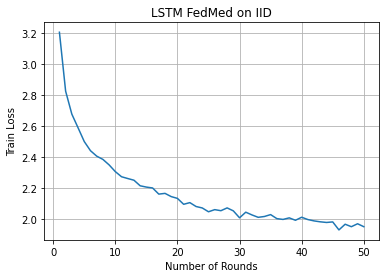

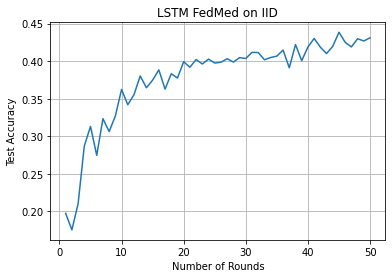

In [ ]:
exp_history = list()
for run_id in range(1):  # TOTAL RUNS
    print(f'============== RUNNING EXPERIMENT #{run_id} ==============')
    exp_history.append(run_experiment(run_id))
    print(f'\n\n========================================================\n\n')

In [ ]:
exp_log[title] = {
    'history': exp_history,
    'hyperparams': hparams.__dict__
}

In [ ]:
df = None
for i, e in enumerate(exp_history):
    if i == 0:
        df = pd.json_normalize(e)
        continue
    df = df + pd.json_normalize(e)
    
df_avg = df / len(exp_history)
avg_history = df_avg.to_dict(orient='records')

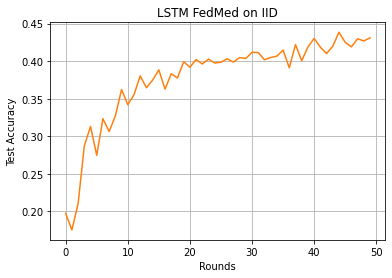

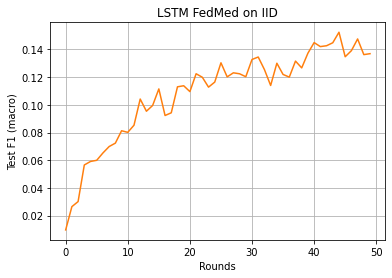

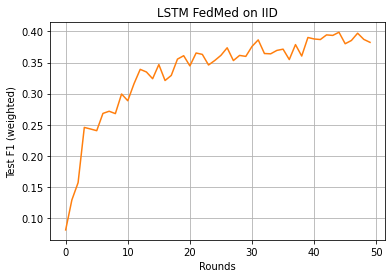

In [ ]:
plot_scores(history=avg_history, exp_id=exp_id, title=title, suffix='IID')

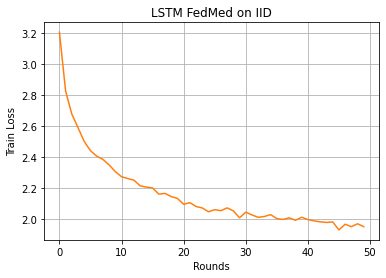

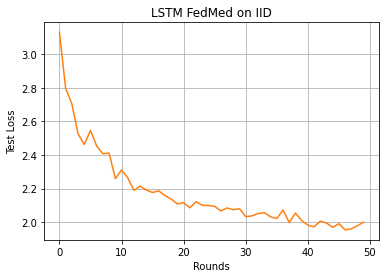

In [ ]:
plot_losses(history=avg_history, exp_id=exp_id, title=title, suffix='IID')

### Non-IID

In [ ]:
train_ds, data_dict, test_ds = noniid_partition(corpus, seq_length=seq_length, val_split=False)

total_clients = len(data_dict.keys())
'Total users:', total_clients

Objective 413629 / 413629


('Total users:', 143)

In [ ]:
hparams = Hyperparameters(total_clients)
hparams.__dict__

{'C': 0.07,
 'E': 1,
 'K': 143,
 'M': 0.01,
 'batch_size': 10,
 'lr': 0.8,
 'rounds': 50}

In [ ]:
# Sweeping parameter
PARAM_NAME = 'clients_fraction'
PARAM_VALUE = hparams.C
exp_id = f'{PARAM_NAME}/{PARAM_VALUE}'
exp_id

'clients_fraction/0.07'

In [ ]:
EXP_DIR = f'{BASE_DIR}/{exp_id}'
os.makedirs(EXP_DIR, exist_ok=True)

# tb_logger = SummaryWriter(log_dir)
# print(f'TBoard logger created at: {log_dir}')

title = 'LSTM FedMed on Non-IID'

In [ ]:
def run_experiment(run_id):

    shakespeare_lstm = ShakespeareLSTM(input_dim=seq_length,  
                                   embedding_dim=embedding_dim,  
                                   hidden_dim=hidden_dim,
                                   classes=num_classes,
                                   lstm_layers=lstm_layers,
                                   dropout=dropout,
                                   batch_first=True
                                   )

    if torch.cuda.is_available():
        shakespeare_lstm.cuda()
    
    test_history = []

    lstm_iid_trained, test_history = training(shakespeare_lstm,
                                            hparams.rounds, hparams.batch_size, hparams.lr,
                                            train_ds,
                                            data_dict,
                                            test_ds,
                                            hparams.C, hparams.K, hparams.E, hparams.M,
                                            title, "green",
                                            corpus, # classes
                                            history=test_history,
                                            # tb_logger=tb_writer
                                            )
    

    final_scores = testing(lstm_iid_trained, test_ds, batch_size * 2, nn.CrossEntropyLoss(), len(corpus), corpus)
    print(f'\n\n========================================================\n\n')
    print(f'Final scores for Exp {run_id} \n {final_scores}')

    return test_history


In [ ]:
exp_history = list()
for run_id in range(1):  # TOTAL RUNS
    print(f'============== RUNNING EXPERIMENT #{run_id} ==============')
    exp_history.append(run_experiment(run_id))
    print(f'\n\n========================================================\n\n')

============== RUNNING EXPERIMENT #0 ==============
Clients: 10/143 -> [117  19  82  97  56  12 131  65  66  18]
Pre..


Client 117: 2 samples


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:662: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:915.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


Client 19: 2 samples
Client 82: 2 samples
Client 97: 2 samples
Client 56: 2 samples
Client 12: 2 samples
Client 131: 2 samples
Client 65: 2 samples
Client 66: 2 samples
Client 18: 2 samples

Computing median...
Round: 1... 	Average Loss: 2.925
running validation...



Test Loss: 2.734095

F1 Score: 0.039722 (macro) 0.171697 (weighted) %


Final Test  Accuracy: 0.235 (24341.0/103477.0)
Clients: 10/143 -> [ 30 117  79 128   3 138   7  45  40  48]
Pre..


Client 30: 2 samples
Client 117: 2 samples
Client 79: 2 samples
Client 128: 2 samples
Client 3: 2 samples
Client 138: 2 samples
Client 7: 2 samples
Client 45: 2 samples
Client 40: 2 samples
Client 48: 2 samples

Computing median...
Round: 2... 	Average Loss: 2.391
running validation...



Test Loss: 2.540086

F1 Score: 0.071680 (macro) 0.252432 (weighted) %


Final Test  Accuracy: 0.300 (30999.0/103477.0)
Clients: 10/143 -> [ 40  49  54  44   2  71  80 102 135  69]
Pre..


Client 40: 2 samples
Client 49: 2 samples
Client 54: 2 samples
Client 44: 2 samples
Client 2: 2 samples
Client 71: 2 samples
Client 80: 2 samples
Client 102: 2 samples
Client 135: 2 samples
Client 69: 2 samples

Computing median...
Round: 3... 	Average Loss: 2.182
running validation...



Test Loss: 2.466871

F1 Score: 0.079033 (macro) 0.273324 (weighted) %


Final Test  Accuracy: 0.319 (33033.0/103477.0)
Clients: 10/143 -> [ 78  70  96 112   5  14 101 113  37  13]
Pre..


Client 78: 2 samples
Client 70: 2 samples
Client 96: 2 samples
Client 112: 2 samples
Client 5: 2 samples
Client 14: 2 samples
Client 101: 2 samples
Client 113: 2 samples
Client 37: 2 samples
Client 13: 2 samples

Computing median...
Round: 4... 	Average Loss: 2.024
running validation...



Test Loss: 2.420030

F1 Score: 0.093399 (macro) 0.306258 (weighted) %


Final Test  Accuracy: 0.348 (35966.0/103477.0)
Clients: 10/143 -> [ 58 128  63  25 101 115  88  95 141  93]
Pre..


Client 58: 2 samples
Client 128: 2 samples
Client 63: 2 samples
Client 25: 2 samples
Client 101: 2 samples
Client 115: 2 samples
Client 88: 2 samples
Client 95: 2 samples
Client 141: 2 samples
Client 93: 2 samples

Computing median...
Round: 5... 	Average Loss: 1.89
running validation...



Test Loss: 2.414704

F1 Score: 0.093915 (macro) 0.308954 (weighted) %


Final Test  Accuracy: 0.347 (35920.0/103477.0)
Clients: 10/143 -> [ 90  87  78  67   6  47  30  57 142  93]
Pre..


Client 90: 2 samples
Client 87: 2 samples
Client 78: 2 samples
Client 67: 2 samples
Client 6: 2 samples
Client 47: 2 samples
Client 30: 2 samples
Client 57: 2 samples
Client 142: 2 samples
Client 93: 2 samples

Computing median...
Round: 6... 	Average Loss: 1.774
running validation...



Test Loss: 2.447507

F1 Score: 0.107873 (macro) 0.325442 (weighted) %


Final Test  Accuracy: 0.362 (37468.0/103477.0)
Clients: 10/143 -> [ 15  61 105  26 124 140  42  96 112  65]
Pre..


Client 15: 2 samples
Client 61: 2 samples
Client 105: 2 samples
Client 26: 2 samples
Client 124: 2 samples
Client 140: 2 samples
Client 42: 2 samples
Client 96: 2 samples
Client 112: 2 samples
Client 65: 2 samples

Computing median...
Round: 7... 	Average Loss: 1.676
running validation...



Test Loss: 2.431744

F1 Score: 0.115826 (macro) 0.335128 (weighted) %


Final Test  Accuracy: 0.350 (36263.0/103477.0)
Clients: 10/143 -> [ 55 101  58  18  91  79 106  60 130 114]
Pre..


Client 55: 2 samples
Client 101: 2 samples
Client 58: 2 samples
Client 18: 2 samples
Client 91: 2 samples
Client 79: 2 samples
Client 106: 2 samples
Client 60: 2 samples
Client 130: 2 samples
Client 114: 2 samples

Computing median...
Round: 8... 	Average Loss: 1.587
running validation...



Test Loss: 2.559309

F1 Score: 0.117641 (macro) 0.336709 (weighted) %


Final Test  Accuracy: 0.365 (37782.0/103477.0)
Clients: 10/143 -> [ 76 102 135 130  26 101  43  11 123  82]
Pre..


Client 76: 2 samples
Client 102: 2 samples
Client 135: 2 samples
Client 130: 2 samples
Client 26: 2 samples
Client 101: 2 samples
Client 43: 2 samples
Client 11: 2 samples
Client 123: 2 samples
Client 82: 2 samples

Computing median...
Round: 9... 	Average Loss: 1.518
running validation...



Test Loss: 2.568344

F1 Score: 0.114719 (macro) 0.337324 (weighted) %


Final Test  Accuracy: 0.355 (36693.0/103477.0)
Clients: 10/143 -> [ 12  92  22  83 127  14  27  82  77  31]
Pre..


Client 12: 2 samples
Client 92: 2 samples
Client 22: 2 samples
Client 83: 2 samples
Client 127: 2 samples
Client 14: 2 samples


In [ ]:
exp_log[title] = {
    'history': exp_history,
    'hyperparams': hparams.__dict__
}

In [ ]:
df = None
for i, e in enumerate(exp_history):
    if i == 0:
        df = pd.json_normalize(e)
        continue
    df = df + pd.json_normalize(e)
    
df_avg = df / len(exp_history)
avg_history = df_avg.to_dict(orient='records')

In [ ]:
plot_scores(history=avg_history, exp_id=exp_id, title=title, suffix='nonIID')

In [ ]:
plot_losses(history=avg_history, exp_id=exp_id, title=title, suffix='nonIID')

### Pickle Experiment Results

In [ ]:
import pickle
 
with open(f'{EXP_DIR}/results_stragglers0_1.pkl', 'wb') as file:
    pickle.dump(exp_log, file)